In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 23.6 MB/s eta 0:00:00


1D Input

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6276 - loss: 10.3808 - val_accuracy: 0.7333 - val_loss: 1.0375
Epoch 2/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7242 - loss: 1.5002 - val_accuracy: 0.7667 - val_loss: 0.5723
Epoch 3/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7312 - loss: 0.7243 - val_accuracy: 0.7448 - val_loss: 0.4990
Epoch 4/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7244 - loss: 0.6370 - val_accuracy: 0.6844 - val_loss: 0.4880
Epoch 5/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7541 - loss: 0.4398 - val_accuracy: 0.7385 - val_loss: 0.3856
Epoch 6/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7762 - loss: 0.4750 - val_accuracy: 0.7792 - val_loss: 0.4106
Epoch 7/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7804 - loss: 0.5138 - val_accuracy: 0.7708 - val_loss: 0.3703
Epoch 8/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8235 - loss: 0.4400 - val_accuracy: 0.6042 - val_loss: 0.6025
E

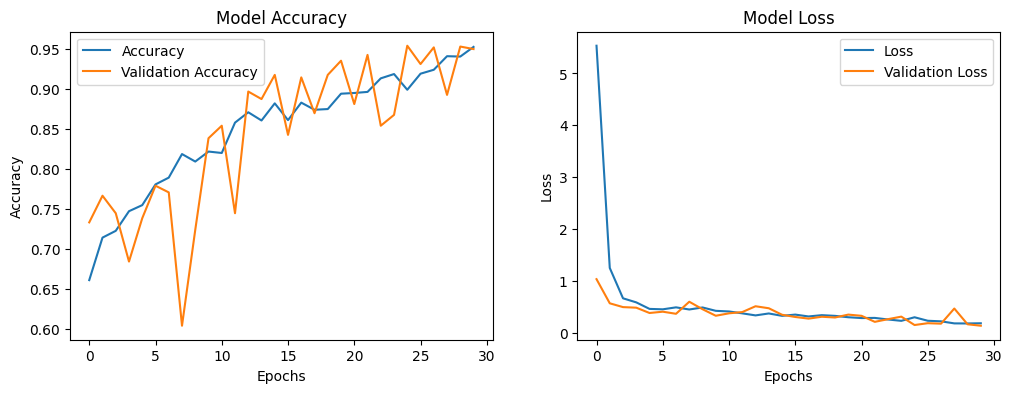

Model saved successfully at /content/drive/MyDrive/Models/Walvet_dec/CNN/Exp1/No_Options.keras ✅


In [3]:
# Import necessary libraries
import os
import numpy as np
import time
import pywt  # For wavelet transform
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

# Function to divide signals into fixed-length segments
def segment_signal(signal, segment_length):
    """
    Divide a 1D signal into non-overlapping segments of specified length.
    If the signal length is not a multiple of segment_length, truncate the remainder.
    """
    num_segments = len(signal) // segment_length
    truncated_length = num_segments * segment_length
    return signal[:truncated_length].reshape(num_segments, segment_length)

# Function to perform Discrete Wavelet Transform (DWT)
def apply_wavelet_transform(data, wavelet='db4', level=5):
    """
    Apply DWT to a 2D array (each row is a signal).
    Returns the approximation coefficients after decomposition.
    """
    transformed_data = []
    for signal in data:
        coeffs = pywt.wavedec(signal, wavelet, level=level)  # Decompose signal
        transformed_data.append(coeffs[0])  # Use approximation coefficients
    return np.array(transformed_data)

# Function to load and preprocess data
def load_and_preprocess_data(directory_path, label, segment_length, wavelet='db4', level=5):
    data = []
    labels = []

    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} not found.")
        return np.array([]), np.array([])

    files = [f for f in os.listdir(directory_path) if f.lower().endswith('.txt')]
    if len(files) == 0:
        print(f"No .txt files found in {directory_path}.")
        return np.array([]), np.array([])

    for filename in files:
        file_path = os.path.join(directory_path, filename)
        try:
            raw_signal = np.loadtxt(file_path)
            if raw_signal.ndim == 1:
                raw_signal = raw_signal.flatten()

            # Step 1: Segment the signal
            segments = segment_signal(raw_signal, segment_length)

            # Step 2: Apply DWT to each segment
            transformed_segments = apply_wavelet_transform(segments, wavelet=wavelet, level=level)

            # Append processed data and labels
            data.extend(transformed_segments)
            labels.extend([label] * len(transformed_segments))
        except Exception as e:
            print(f"Error loading {filename}: {e}")

    return np.array(data), np.array(labels)

# Paths to datasets
path_Z = '/content/drive/My Drive/PFA2_DataSet/DataSet/Healthy/Z'
path_S = '/content/drive/My Drive/PFA2_DataSet/DataSet/Seizeur/S'

# Start timing preprocessing
start_preprocessing = time.time()

# Load and preprocess data
segment_length = 256  # Example: segment length of 256
data_Z, labels_Z = load_and_preprocess_data(path_Z, label=0, segment_length=segment_length)
data_S, labels_S = load_and_preprocess_data(path_S, label=1, segment_length=segment_length)

# Combine data and labels
end_preprocessing = time.time()

if data_Z.size > 0 and data_S.size > 0:
    data_all = np.concatenate((data_Z, data_S), axis=0)
    labels_all = np.concatenate((labels_Z, labels_S), axis=0)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_all, labels_all, test_size=0.3, random_state=42)

    # Define the CNN model for 1D input
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification
    ])

    # Compile the model
    model.compile(loss='binary_crossentropy', metrics=['accuracy'])

    # Start timing training
    start_training = time.time()

    # Train the model
    history = model.fit(X_train[..., np.newaxis], y_train, epochs=30, batch_size=32, validation_data=(X_test[..., np.newaxis], y_test), verbose=1)

    # End timing training
    end_training = time.time()

    # Evaluate the model
    y_pred = model.predict(X_test[..., np.newaxis])
    y_pred_classes = (y_pred > 0.5).astype("int32")  # Convert probabilities to class labels

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes)  # Sensitivity
    precision = precision_score(y_test, y_pred_classes)
    conf_matrix = confusion_matrix(y_test, y_pred_classes)

    # Specificity calculation
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)

    # Print metrics
    print("\nPreprocessing Time: {:.2f} seconds".format(end_preprocessing - start_preprocessing))
    print("Training Time: {:.2f} seconds".format(end_training - start_training))
    print("\nFinal Evaluation Metrics:")
    print("Test Accuracy: ", accuracy)
    print("Test Recall (Sensitivity): ", recall)
    print("Test Precision: ", precision)
    print("Test Specificity: ", specificity)
    print("Confusion Matrix: \n", conf_matrix)

    # Plot Training History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")


     # Define the model path
model_path = "/content/drive/MyDrive/Models/Walvet_dec/CNN/Exp1/No_Options.keras"

# Save the model
model.save(model_path)

print(f"Model saved successfully at {model_path} ✅")


with stranderscaler

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 883ms/step - accuracy: 0.4766 - loss: 5.7479 - val_accuracy: 0.4833 - val_loss: 0.4276
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7300 - loss: 0.4366 - val_accuracy: 1.0000 - val_loss: 0.3180
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.8972 - loss: 0.3399 - val_accuracy: 0.9833 - val_loss: 0.2552
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.9922 - loss: 0.1424 - val_accuracy: 0.9833 - val_loss: 0.1736
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 785ms/step - accuracy: 1.0000 - loss: 0.0889 - val_accuracy: 0.9000 - val_loss: 0.4950
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 673ms/step - accuracy: 0.7920 - loss: 0.6799 - val_accuracy: 0.9667 - val_loss: 0.1306
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 889ms/step - accuracy: 0.9840 - loss: 0.0742 - val_accuracy: 0.9667 - val_loss: 0.1030
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 905ms/step - accuracy: 1.0000 - loss: 0.0481 - val_accuracy: 0.9833 - val_loss: 0.0555


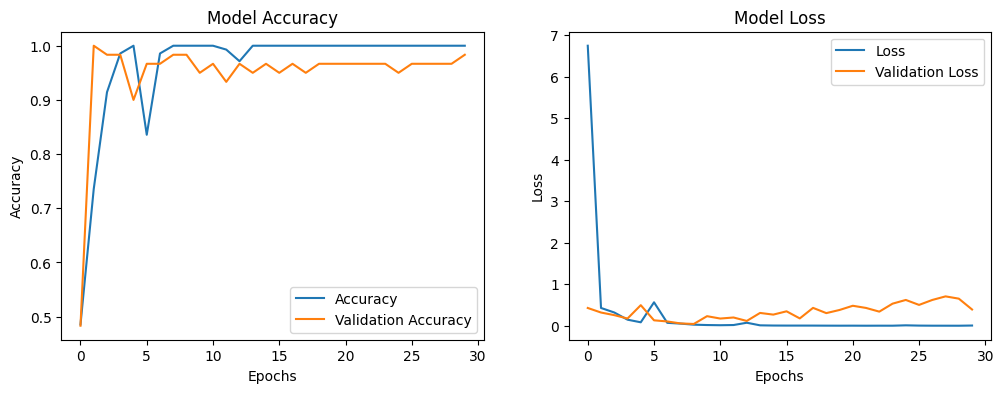

Model saved successfully at /content/drive/MyDrive/Models/Walvet_dec/CNN/Exp1/With_Stander.keras ✅


In [4]:
import os
import numpy as np
import pywt  # Import PyWavelets for wavelet processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

# Function to load data
def load_data_from_directory(directory_path, label):
    data = []
    labels = []

    # Check if the directory exists
    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} not found.")
        return np.array([]), np.array([])

    # List all files in the directory
    files = [f for f in os.listdir(directory_path) if f.lower().endswith('.txt')]  # Only .txt files

    if len(files) == 0:
        print(f"No .txt files found in {directory_path}.")
        return np.array([]), np.array([])

    # Load data from each file
    for filename in files:
        file_path = os.path.join(directory_path, filename)
        try:
            file_data = np.loadtxt(file_path)
            data.append(file_data)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

    return np.array(data, dtype=np.float32), np.array(labels)

# Function for wavelet transform (db4, level 5)
def wavelet_transform(data, wavelet='db4', level=5):
    transformed_data = []
    for signal in data:
        coeffs = pywt.wavedec(signal, wavelet, level=level)  # Decompose signal
        coeffs_flattened = np.hstack(coeffs)  # Flatten all coefficients
        transformed_data.append(coeffs_flattened)
    return np.array(transformed_data)

# Paths to your datasets
path_Z = '/content/drive/My Drive/PFA2_DataSet/DataSet/Healthy/Z'
path_S = '/content/drive/My Drive/PFA2_DataSet/DataSet/Seizeur/S'

# Load data
data_Z, labels_Z = load_data_from_directory(path_Z, label=0)  # Healthy (Z)
data_S, labels_S = load_data_from_directory(path_S, label=1)  # Seizure (S)

# Combine data and labels
if data_Z.size > 0 and data_S.size > 0:
    data_all = np.concatenate((data_Z, data_S), axis=0)
    labels_all = np.concatenate((labels_Z, labels_S), axis=0)

    # Apply wavelet transform (db4, level 5)
    data_all_wavelet = wavelet_transform(data_all, wavelet='db4', level=5)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_all_wavelet, labels_all, test_size=0.3, random_state=42)

    # Normalize the data using StandardScaler
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Define the CNN model for 1D input
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification
    ])

    # Compile the model
    model.compile(loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train[..., np.newaxis], y_train, epochs=30, batch_size=32, validation_data=(X_test[..., np.newaxis], y_test), verbose=1)

    # Evaluate the model
    y_pred = model.predict(X_test[..., np.newaxis])
    y_pred_classes = (y_pred > 0.5).astype("int32")  # Convert probabilities to class labels

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes)  # Sensitivity
    precision = precision_score(y_test, y_pred_classes)
    conf_matrix = confusion_matrix(y_test, y_pred_classes)

    # Specificity calculation
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)

    # Print metrics
    print("\nFinal Evaluation Metrics:")
    print("Test Accuracy: ", accuracy)
    print("Test Recall (Sensitivity): ", recall)
    print("Test Precision: ", precision)
    print("Test Specificity: ", specificity)
    print("Confusion Matrix: \n", conf_matrix)

    # Plot Training History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")



    # Define the model path
model_path = "/content/drive/MyDrive/Models/Walvet_dec/CNN/Exp1/With_Stander.keras"

# Save the model
model.save(model_path)

print(f"Model saved successfully at {model_path} ✅")



with optimiser

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.4866 - loss: 74.3743 - val_accuracy: 0.6333 - val_loss: 28.9241
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5921 - loss: 52.3073 - val_accuracy: 0.5500 - val_loss: 16.5435
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6537 - loss: 12.5247 - val_accuracy: 0.6000 - val_loss: 4.7196
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7554 - loss: 3.7867 - val_accuracy: 0.9667 - val_loss: 0.7226
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8972 - loss: 0.8351 - val_accuracy: 0.9167 - val_loss: 0.3330
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.8593 - loss: 0.6131 - val_accuracy: 0.9000 - val_loss: 0.4015
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.8764 - loss: 0.5085 - val_accuracy: 0.9667 - val_loss: 0.2037
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9347 - loss: 0.3536 - val_accuracy: 0.9667 - val_loss: 0.1123
Epoch

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step

Final Evaluation Metrics:
Test Accuracy:  0.9666666666666667
Test Recall (Sensitivity):  0.9310344827586207
Test Precision:  1.0
Test Specificity:  1.0
Confusion Matrix: 
 [[31  0]
 [ 2 27]]
Training Time: 12.02 seconds


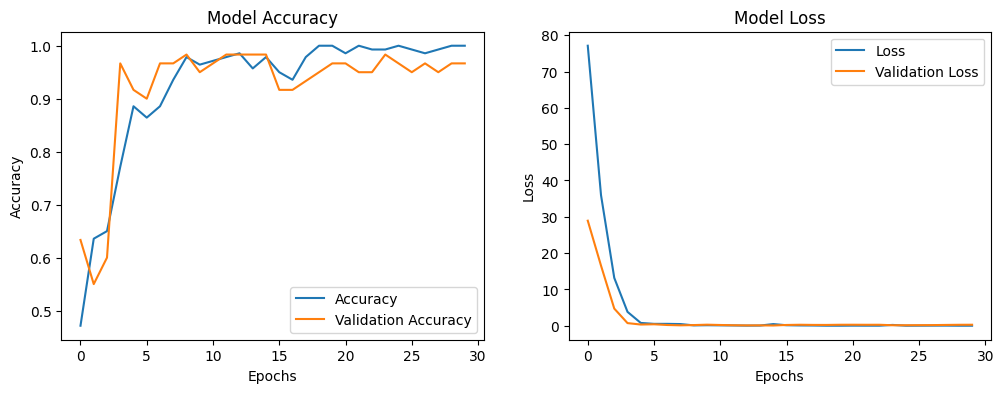

Model saved successfully at /content/drive/MyDrive/Models/Walvet_dec/CNN/Exp1/With_Optimiser.keras ✅


In [ ]:
# Import necessary libraries
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
import pywt
import time  # For tracking training time

# Function to load data
def load_data_from_directory(directory_path, label):
    data = []
    labels = []

    # Check if the directory exists
    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} not found.")
        return np.array([]), np.array([])

    # List all files in the directory
    files = [f for f in os.listdir(directory_path) if f.lower().endswith('.txt')]  # Only .txt files

    if len(files) == 0:
        print(f"No .txt files found in {directory_path}.")
        return np.array([]), np.array([])

    # Load data from each file
    for filename in files:
        file_path = os.path.join(directory_path, filename)
        try:
            file_data = np.loadtxt(file_path)
            data.append(file_data)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

    return np.array(data, dtype=np.float32), np.array(labels)

# Function to apply wavelet transform (Level 5 Daubechies 4)
def wavelet_transform(data, level=5):
    transformed_data = []
    for signal in data:
        coeffs = pywt.wavedec(signal, 'db4', level=level)
        # Only use the approximation (low-frequency) coefficients for simplicity
        approximation = coeffs[0]
        transformed_data.append(approximation)
    return np.array(transformed_data)

# Paths to your datasets
path_Z = '/content/drive/My Drive/PFA2_DataSet/DataSet/Healthy/Z'
path_S = '/content/drive/My Drive/PFA2_DataSet/DataSet/Seizeur/S'

# Load data
data_Z, labels_Z = load_data_from_directory(path_Z, label=0)  # Healthy (Z)
data_S, labels_S = load_data_from_directory(path_S, label=1)  # Seizure (S)

# Combine data and labels
if data_Z.size > 0 and data_S.size > 0:
    data_all = np.concatenate((data_Z, data_S), axis=0)
    labels_all = np.concatenate((labels_Z, labels_S), axis=0)

    # Apply wavelet transform to the data
    data_all_wavelet = wavelet_transform(data_all)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_all_wavelet, labels_all, test_size=0.3, random_state=42)

    # Define the CNN model for 1D input
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification
    ])

    # Compile the model with Adam optimizer
    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

    # Record training start time
    start_time = time.time()

    # Train the model
    history = model.fit(X_train[..., np.newaxis], y_train, epochs=30, batch_size=32, validation_data=(X_test[..., np.newaxis], y_test), verbose=1)

    # Record training end time
    end_time = time.time()
    training_time = end_time - start_time

    # Evaluate the model
    y_pred = model.predict(X_test[..., np.newaxis])
    y_pred_classes = (y_pred > 0.5).astype("int32")  # Convert probabilities to class labels

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes)  # Sensitivity
    precision = precision_score(y_test, y_pred_classes)
    conf_matrix = confusion_matrix(y_test, y_pred_classes)

    # Specificity calculation
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)

    # Print metrics
    print("\nFinal Evaluation Metrics:")
    print("Test Accuracy: ", accuracy)
    print("Test Recall (Sensitivity): ", recall)
    print("Test Precision: ", precision)
    print("Test Specificity: ", specificity)
    print("Confusion Matrix: \n", conf_matrix)
    print("Training Time: {:.2f} seconds".format(training_time))

    # Plot Training History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")


     # Define the model path
model_path = "/content/drive/MyDrive/Models/Walvet_dec/CNN/Exp1/With_Optimiser.keras"

# Save the model
model.save(model_path)

print(f"Model saved successfully at {model_path} ✅")


With both opt and  and stand

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.4937 - loss: 0.6372
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6294 - loss: 0.4671
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9245 - loss: 0.3807
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9530 - loss: 0.2595
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9558 - loss: 0.1758
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9803 - loss: 0.1118
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9681 - loss: 0.0799
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9892 - loss: 0.0568
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9866 - loss: 0.0551
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9562 - loss: 0.0955
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9922 - loss: 0.0404
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9829 - loss: 0.0389
Epoch 13/30


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step

Final Evaluation Metrics:
Test Accuracy:  0.9666666666666667
Test Recall (Sensitivity):  0.9310344827586207
Test Precision:  1.0
Test Specificity:  1.0
Confusion Matrix: 
 [[31  0]
 [ 2 27]]
Training Time: 8.66 seconds


KeyError: 'accuracy'

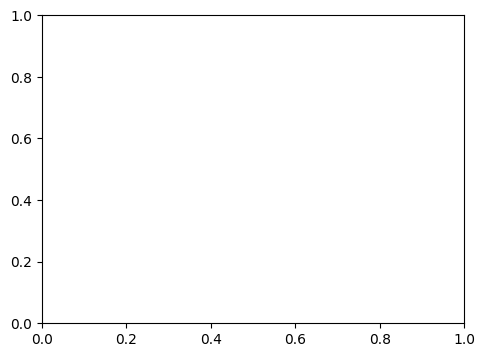

In [ ]:
# Import necessary libraries
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
import pywt
import time  # For tracking training time
from sklearn.preprocessing import StandardScaler

# Function to load data
def load_data_from_directory(directory_path, label):
    data = []
    labels = []

    # Check if the directory exists
    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} not found.")
        return np.array([]), np.array([])

    # List all files in the directory
    files = [f for f in os.listdir(directory_path) if f.lower().endswith('.txt')]  # Only .txt files

    if len(files) == 0:
        print(f"No .txt files found in {directory_path}.")
        return np.array([]), np.array([])

    # Load data from each file
    for filename in files:
        file_path = os.path.join(directory_path, filename)
        try:
            file_data = np.loadtxt(file_path)
            data.append(file_data)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

    return np.array(data, dtype=np.float32), np.array(labels)

# Function to apply wavelet transform (Level 5 Daubechies 4)
def wavelet_transform(data, level=5):
    transformed_data = []
    for signal in data:
        coeffs = pywt.wavedec(signal, 'db4', level=level)
        # Only use the approximation (low-frequency) coefficients for simplicity
        approximation = coeffs[0]
        transformed_data.append(approximation)
    return np.array(transformed_data)

# Function to standardize the data
def standardize_data(data):
    scaler = StandardScaler()
    return scaler.fit_transform(data)

# Paths to your datasets
path_Z = '/content/drive/My Drive/PFA2_DataSet/DataSet/Healthy/Z'
path_S = '/content/drive/My Drive/PFA2_DataSet/DataSet/Seizeur/S'

# Load data
data_Z, labels_Z = load_data_from_directory(path_Z, label=0)  # Healthy (Z)
data_S, labels_S = load_data_from_directory(path_S, label=1)  # Seizure (S)

# Combine data and labels
if data_Z.size > 0 and data_S.size > 0:
    data_all = np.concatenate((data_Z, data_S), axis=0)
    labels_all = np.concatenate((labels_Z, labels_S), axis=0)

    # Apply wavelet transform to the data
    data_all_wavelet = wavelet_transform(data_all)

    # Standardize the wavelet-transformed data
    data_all_standardized = standardize_data(data_all_wavelet)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_all_standardized, labels_all, test_size=0.3, random_state=42)

    # Define the CNN model for 1D input
    def create_model(filters=64, kernel_size=3, learning_rate=0.001):
        model = Sequential([
            Conv1D(filters, kernel_size=kernel_size, activation='relu', input_shape=(X_train.shape[1], 1)),
            MaxPooling1D(pool_size=2),
            Conv1D(filters * 2, kernel_size=kernel_size, activation='relu'),
            MaxPooling1D(pool_size=2),
            Flatten(),
            Dense(128, activation='relu'),
            Dropout(0.5),
            Dense(1, activation='sigmoid')  # Binary classification
        ])
        model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])
        return model

    # Record training start time
    start_time = time.time()

    # Create and train the model
    model = create_model()

    # Train the model on the data
    model.fit(X_train[..., np.newaxis], y_train, epochs=30, batch_size=32, verbose=1)

    # Record training end time
    end_time = time.time()
    training_time = end_time - start_time

    # Evaluate the model
    y_pred = model.predict(X_test[..., np.newaxis])
    y_pred_classes = (y_pred > 0.5).astype("int32")  # Convert probabilities to class labels

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes)  # Sensitivity
    precision = precision_score(y_test, y_pred_classes)
    conf_matrix = confusion_matrix(y_test, y_pred_classes)

    # Specificity calculation
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)

    # Print metrics
    print("\nFinal Evaluation Metrics:")
    print("Test Accuracy: ", accuracy)
    print("Test Recall (Sensitivity): ", recall)
    print("Test Precision: ", precision)
    print("Test Specificity: ", specificity)
    print("Confusion Matrix: \n", conf_matrix)
    print("Training Time: {:.2f} seconds".format(training_time))

    # Plot Training History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(model.history.history['accuracy'], label='Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(model.history.history['loss'], label='Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")




     # Define the model path
model_path = "/content/drive/MyDrive/Models/Walvet_dec/CNN/Exp1/With_Options.keras"

# Save the model
model.save(model_path)

print(f"Model saved successfully at {model_path} ✅")
